In [2]:
import warnings
import numpy as np
from tensorflow.keras.layers import Input, Dense, Lambda, Concatenate, Conv2D, Conv2DTranspose, Flatten, Reshape, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam
import cv2
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

warnings.filterwarnings('ignore')

In [3]:
import h5py
with h5py.File("/home/danielaguirre/Documents/university/masteringml/MML-project/data/processed_data.h5", "r") as f:
    imgs_train, labels_train = np.array(f["X_train"]), np.array(f["y_train"])
    imgs_test, labels_test = np.array(f["X_test"]), np.array(f["y_test"])

imgs_train2 = []
imgs_test2 = []
for img in imgs_train:
    new_img = cv2.resize(img, (128,128))
    new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
    imgs_train2.append(new_img)
for img in imgs_test:
    new_img = cv2.resize(img, (128,128))
    new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
    imgs_test2.append(new_img)
imgs_train = np.array(imgs_train2)[:, :, :, np.newaxis]
imgs_test = np.array(imgs_test2)[:, :, :, np.newaxis]
imgs_train2 = (imgs_train-127.5)/127.5
imgs_test2 = (imgs_test-127.5)/127.5

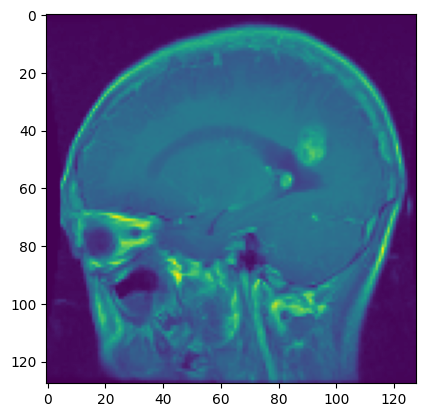

In [4]:
plt.imshow(imgs_train[0])

In [20]:
batch_size = 128 # batch size
latent_dim = 256 # latent space size
optim = Adam(lr=0.0001)
shape_img = imgs_train.shape[1:]
n_cat = labels_train.shape[1]
n_epoch = 300

### Encoder

In [21]:
enc_input_image = Input(shape=(shape_img), name="input_image")
enc_input_label = Input(shape=(n_cat), name="input_label")

# convolutionals block
enc_conv1 = Conv2D(filters=32, kernel_size=3, strides=2, padding="same", activation="relu")(enc_input_image) # 68x68
enc_conv2 = Conv2D(filters=64, kernel_size=3, strides=2, padding="same", activation='relu')(enc_conv1) #  skip-connection 32x32
drop_out = Dropout(rate=0.3)(enc_conv2)
enc_conv3 = Conv2D(filters=128, kernel_size=3, strides=2, padding="same", activation='relu')(drop_out) # 16x16
drop_out = Dropout(rate=0.3)(enc_conv3)
enc_conv4 = Conv2D(filters=256, kernel_size=3, padding="same", activation='relu')(drop_out)  #  skip-connection # 16x16
enc_conv5 = Conv2D(filters=512, kernel_size=3, padding="same", activation='relu')(enc_conv4)  #  skip-connection # 16x16

# concat
flattened = Flatten()(enc_conv5)
enc_concat = Concatenate()([flattened, enc_input_label])

encoder_hidden = Dense(1048, name="enc_hidden_layer")(enc_concat)
drop_out = Dropout(rate=0.3)(encoder_hidden)
encoder_hidden = Dense(512, name="enc_hidden_layer2")(drop_out)

mu = Dense(latent_dim, activation='linear', name="mu")(encoder_hidden)
l_sigma = Dense(latent_dim, activation='linear', name="l_sigma")(encoder_hidden)
def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=(latent_dim, ), mean=0., stddev=1.) # shape antes => (batch_size, latent_dim)
    return mu + K.exp(l_sigma / 2) * eps
z = Lambda(sample_z, output_shape = (latent_dim, ), name="latent_vector")([mu, l_sigma]) # output encoder

encoder = Model([enc_input_image, enc_input_label], z, name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 64, 64, 32)   320         ['input_image[0][0]']            
                                                                                                  
 conv2d_25 (Conv2D)             (None, 32, 32, 64)   18496       ['conv2d_24[0][0]']              
                                                                                                  
 dropout_43 (Dropout)           (None, 32, 32, 64)   0           ['conv2d_25[0][0]']        

### Decoder

In [22]:
dec_inp_latent_vector = Input(shape=(latent_dim), name="input_latent_vector")
decoder_inp_label = Input(shape=(n_cat), name = "input_label")
dec_concat = Concatenate(name="decoder_concat")([dec_inp_latent_vector, decoder_inp_label])

decoder_hidden = Dense(512, activation="relu", name="hidden_layer1")(dec_concat)
decoder_hidden = Dense(512, activation="relu", name="hidden_layer2")(decoder_hidden)
decoder_hidden = Dropout(0.3)(decoder_hidden)
decoder_hidden = Dense(512, activation="relu", name="hidden_layer3")(decoder_hidden)
decoder_hidden = Dense(512, activation="relu", name="hidden_layer4")(decoder_hidden)
decoder_hidden = Dropout(0.3)(decoder_hidden)
decoder_hidden = Dense(512, activation="relu", name="hidden_layer5")(decoder_hidden)
decoder_hidden = Dense(1048, activation="relu", name="hidden_layer6")(decoder_hidden)
decoder_hidden = Dropout(rate=0.3)(decoder_hidden)
decoder_hidden = Dense(16*16*32, activation="relu", name="hidden_layer7")(decoder_hidden)
reshaped = Reshape(target_shape=(16,16,32))(decoder_hidden)

# convolutionals block
dec_conv1 = Conv2D(filters=512, kernel_size=3, padding="same", activation='relu')(reshaped)  #  skip-connection # 16x16
dec_conv1 = Conv2DTranspose(filters=256, kernel_size=3, activation="relu", padding='same')(dec_conv1)
dec_conv1 = Dropout(rate=0.3)(dec_conv1)
dec_conv2 = Conv2DTranspose(filters=128, kernel_size=3, activation="relu", strides=2, padding='same')(dec_conv1)
dec_conv3 = Conv2DTranspose(filters=64, kernel_size=3, activation="relu", strides=2, padding='same')(dec_conv2)
dec_conv3 = Dropout(rate=0.3)(dec_conv3)
dec_conv4 = Conv2DTranspose(filters=32, kernel_size=3, activation="relu", strides=2, padding='same')(dec_conv3)

dec_output_img = Conv2DTranspose(filters=1, kernel_size=3, padding="same", activation="sigmoid")(dec_conv4)
dec_output_img = Flatten()(dec_output_img)
decoder = Model([dec_inp_latent_vector, decoder_inp_label], dec_output_img, name="decoder")
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_latent_vector (InputLaye  [(None, 256)]       0           []                               
 r)                                                                                               
                                                                                                  
 input_label (InputLayer)       [(None, 4)]          0           []                               
                                                                                                  
 decoder_concat (Concatenate)   (None, 260)          0           ['input_latent_vector[0][0]',    
                                                                  'input_label[0][0]']            
                                                                                            

### Conditional Variational autoencoder

In [23]:
latent_vector = encoder(inputs=[enc_input_image, enc_input_label]) # z
output_img = decoder(inputs=[latent_vector, enc_input_label])
CVAE = Model(inputs=[enc_input_image, enc_input_label], outputs=output_img, name="CVAE")
CVAE.summary()

Model: "CVAE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_label (InputLayer)       [(None, 4)]          0           []                               
                                                                                                  
 encoder (Functional)           (None, 256)          139736440   ['input_image[0][0]',            
                                                                  'input_label[0][0]']            
                                                                                               

## Entrenamiento

In [24]:
def vae_loss(y_true, y_pred):
    recon = recon_loss(y_true, y_pred)
    kl = KL_loss(y_true, y_pred)
    return recon + kl

def KL_loss(y_true, y_pred): # it doesnt use y_true and y_pred but the parameters are necessary for compiling
     # importante se usan las capas de mu y sigma del encoder
    return(0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [25]:
CVAE.compile(optimizer=optim, loss=vae_loss, metrics=[KL_loss, recon_loss])

In [26]:
# the output of the decoder is a flattened img, 
# so we need to flatten the true values (input images from (28,28,1) => 784)
y_train = imgs_train.reshape(imgs_train.shape[0], -1)
y_test = imgs_test.reshape(imgs_test.shape[0], -1)
print(y_train.shape)

(2937, 16384)


In [27]:
cvae_hist = CVAE.fit([imgs_train2, labels_train], y_train/255, verbose = 1, batch_size=batch_size, epochs=n_epoch,
                      validation_data = ([imgs_test2, labels_test], y_test/255))

Train on 2937 samples, validate on 327 samples


2023-07-25 01:18:53.976470: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-25 01:18:53.976631: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-25 01:18:53.976732: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/300


2023-07-25 01:19:03.204032: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indropout_43/cond/then/_840/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-07-25 01:19:03.846813: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-25 01:19:04.199880: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-25 01:19:04.200284: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-25 01:19:04.200300: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Couldn't invoke ptxas --version
2023-07-25 01:19:04.200785: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spaw

2937/2937 [==============================] - ETA: 0s - loss: 10191.9246 - KL_loss: 48.9756 - recon_loss: 10142.9492

2023-07-25 01:19:12.073402: W tensorflow/c/c_api.cc:300] Operation '{name:'loss/mul' id:5304 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/decoder_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-07-25 01:19:12.241191: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indropout_43/cond/then/_840/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2937/2937 [==============================] - 10s 3ms/sample - loss: 10191.9246 - KL_loss: 48.9756 - recon_loss: 10142.9492 - val_loss: 8411.1209 - val_KL_loss: 11.5814 - val_recon_loss: 8399.5400
Epoch 2/300
2937/2937 [==============================] - 3s 957us/sample - loss: 7861.8500 - KL_loss: 19.6805 - recon_loss: 7842.1694 - val_loss: 7908.7129 - val_KL_loss: 4.1557 - val_recon_loss: 7904.5571
Epoch 3/300
2937/2937 [==============================] - 3s 956us/sample - loss: 7436.9408 - KL_loss: 20.7679 - recon_loss: 7416.1729 - val_loss: 7130.4277 - val_KL_loss: 25.2653 - val_recon_loss: 7105.1621
Epoch 4/300
2937/2937 [==============================] - 3s 951us/sample - loss: 7121.1259 - KL_loss: 39.9886 - recon_loss: 7081.1367 - val_loss: 6949.5894 - val_KL_loss: 43.7267 - val_recon_loss: 6905.8633
Epoch 5/300
2937/2937 [==============================] - 3s 954us/sample - loss: 7019.3744 - KL_loss: 33.6818 - recon_loss: 6985.6934 - val_loss: 6873.2113 - val_KL_loss: 33.6344 - val

2937/2937 [==============================] - 3s 951us/sample - loss: 6753.3740 - KL_loss: 21.7165 - recon_loss: 6731.6582 - val_loss: 6683.7580 - val_KL_loss: 20.4193 - val_recon_loss: 6663.3394
Epoch 41/300
2937/2937 [==============================] - 3s 953us/sample - loss: 6762.2227 - KL_loss: 22.4029 - recon_loss: 6739.8188 - val_loss: 6647.3834 - val_KL_loss: 18.9838 - val_recon_loss: 6628.3999
Epoch 42/300
2937/2937 [==============================] - 3s 951us/sample - loss: 6755.5406 - KL_loss: 20.2985 - recon_loss: 6735.2422 - val_loss: 6769.2142 - val_KL_loss: 19.8488 - val_recon_loss: 6749.3652
Epoch 43/300
2937/2937 [==============================] - 3s 954us/sample - loss: 6735.8885 - KL_loss: 21.4100 - recon_loss: 6714.4785 - val_loss: 6764.2323 - val_KL_loss: 20.2708 - val_recon_loss: 6743.9619
Epoch 44/300
2937/2937 [==============================] - 3s 953us/sample - loss: 6736.1053 - KL_loss: 23.0035 - recon_loss: 6713.1025 - val_loss: 6716.2341 - val_KL_loss: 20.5043 -

2937/2937 [==============================] - 3s 951us/sample - loss: 6683.0868 - KL_loss: 30.9471 - recon_loss: 6652.1396 - val_loss: 6687.0919 - val_KL_loss: 27.2331 - val_recon_loss: 6659.8584
Epoch 80/300
2937/2937 [==============================] - 3s 948us/sample - loss: 6676.0053 - KL_loss: 30.0503 - recon_loss: 6645.9546 - val_loss: 6641.7310 - val_KL_loss: 26.7354 - val_recon_loss: 6614.9956
Epoch 81/300
2937/2937 [==============================] - 3s 952us/sample - loss: 6650.1415 - KL_loss: 31.4848 - recon_loss: 6618.6562 - val_loss: 6694.9411 - val_KL_loss: 25.8338 - val_recon_loss: 6669.1069
Epoch 82/300
2937/2937 [==============================] - 3s 952us/sample - loss: 6644.4419 - KL_loss: 28.3634 - recon_loss: 6616.0776 - val_loss: 6724.4824 - val_KL_loss: 27.9960 - val_recon_loss: 6696.4863
Epoch 83/300
2937/2937 [==============================] - 3s 953us/sample - loss: 6654.7402 - KL_loss: 30.0247 - recon_loss: 6624.7158 - val_loss: 6573.5041 - val_KL_loss: 30.4893 -

2937/2937 [==============================] - 3s 953us/sample - loss: 6652.9466 - KL_loss: 33.5668 - recon_loss: 6619.3804 - val_loss: 6632.9975 - val_KL_loss: 34.3443 - val_recon_loss: 6598.6538
Epoch 119/300
2937/2937 [==============================] - 3s 954us/sample - loss: 6625.8911 - KL_loss: 34.0159 - recon_loss: 6591.8755 - val_loss: 6573.2733 - val_KL_loss: 33.0170 - val_recon_loss: 6540.2563
Epoch 120/300
2937/2937 [==============================] - 3s 954us/sample - loss: 6606.1558 - KL_loss: 31.5873 - recon_loss: 6574.5688 - val_loss: 6628.2438 - val_KL_loss: 33.3383 - val_recon_loss: 6594.9053
Epoch 121/300
2937/2937 [==============================] - 3s 953us/sample - loss: 6632.4851 - KL_loss: 33.0212 - recon_loss: 6599.4648 - val_loss: 6660.9762 - val_KL_loss: 33.8580 - val_recon_loss: 6627.1187
Epoch 122/300
2937/2937 [==============================] - 3s 952us/sample - loss: 6636.6828 - KL_loss: 36.7884 - recon_loss: 6599.8945 - val_loss: 6595.2015 - val_KL_loss: 36.02

2937/2937 [==============================] - 3s 943us/sample - loss: 6572.8705 - KL_loss: 36.4946 - recon_loss: 6536.3765 - val_loss: 6516.7747 - val_KL_loss: 40.8232 - val_recon_loss: 6475.9517
Epoch 158/300
2937/2937 [==============================] - 3s 941us/sample - loss: 6585.6783 - KL_loss: 40.5048 - recon_loss: 6545.1738 - val_loss: 6533.2925 - val_KL_loss: 40.8037 - val_recon_loss: 6492.4893
Epoch 159/300
2937/2937 [==============================] - 3s 941us/sample - loss: 6568.3055 - KL_loss: 37.2706 - recon_loss: 6531.0342 - val_loss: 6516.4379 - val_KL_loss: 35.9071 - val_recon_loss: 6480.5308
Epoch 160/300
2937/2937 [==============================] - 3s 942us/sample - loss: 6574.6359 - KL_loss: 37.7191 - recon_loss: 6536.9180 - val_loss: 6554.5540 - val_KL_loss: 39.5099 - val_recon_loss: 6515.0435
Epoch 161/300
2937/2937 [==============================] - 3s 943us/sample - loss: 6568.7414 - KL_loss: 35.6275 - recon_loss: 6533.1143 - val_loss: 6493.9070 - val_KL_loss: 35.65

2937/2937 [==============================] - 3s 943us/sample - loss: 6522.1864 - KL_loss: 36.8232 - recon_loss: 6485.3633 - val_loss: 6484.3556 - val_KL_loss: 41.6816 - val_recon_loss: 6442.6733
Epoch 197/300
2937/2937 [==============================] - 3s 942us/sample - loss: 6513.3907 - KL_loss: 39.2502 - recon_loss: 6474.1401 - val_loss: 6452.3348 - val_KL_loss: 40.0654 - val_recon_loss: 6412.2700
Epoch 198/300
2937/2937 [==============================] - 3s 941us/sample - loss: 6528.0953 - KL_loss: 43.1131 - recon_loss: 6484.9824 - val_loss: 6427.3023 - val_KL_loss: 48.4572 - val_recon_loss: 6378.8452
Epoch 199/300
2937/2937 [==============================] - 3s 941us/sample - loss: 6514.1065 - KL_loss: 38.3046 - recon_loss: 6475.8018 - val_loss: 6440.6912 - val_KL_loss: 40.9938 - val_recon_loss: 6399.6968
Epoch 200/300
2937/2937 [==============================] - 3s 941us/sample - loss: 6525.4839 - KL_loss: 42.1504 - recon_loss: 6483.3335 - val_loss: 6417.7017 - val_KL_loss: 44.69

2937/2937 [==============================] - 3s 940us/sample - loss: 6475.2670 - KL_loss: 48.7704 - recon_loss: 6426.4966 - val_loss: 6397.6162 - val_KL_loss: 44.5915 - val_recon_loss: 6353.0244
Epoch 236/300
2937/2937 [==============================] - 3s 940us/sample - loss: 6486.8708 - KL_loss: 44.1007 - recon_loss: 6442.7710 - val_loss: 6393.6540 - val_KL_loss: 49.8727 - val_recon_loss: 6343.7812
Epoch 237/300
2937/2937 [==============================] - 3s 940us/sample - loss: 6489.9233 - KL_loss: 45.4868 - recon_loss: 6444.4360 - val_loss: 6382.2034 - val_KL_loss: 46.1976 - val_recon_loss: 6336.0063
Epoch 238/300
2937/2937 [==============================] - 3s 941us/sample - loss: 6478.6576 - KL_loss: 42.7550 - recon_loss: 6435.9019 - val_loss: 6403.4544 - val_KL_loss: 43.7909 - val_recon_loss: 6359.6631
Epoch 239/300
2937/2937 [==============================] - 3s 939us/sample - loss: 6486.0441 - KL_loss: 46.9595 - recon_loss: 6439.0840 - val_loss: 6386.2531 - val_KL_loss: 49.25

2937/2937 [==============================] - 3s 938us/sample - loss: 6443.6765 - KL_loss: 51.2586 - recon_loss: 6392.4170 - val_loss: 6355.3977 - val_KL_loss: 47.8537 - val_recon_loss: 6307.5439
Epoch 275/300
2937/2937 [==============================] - 3s 937us/sample - loss: 6454.0162 - KL_loss: 52.4304 - recon_loss: 6401.5864 - val_loss: 6349.6446 - val_KL_loss: 53.6852 - val_recon_loss: 6295.9600
Epoch 276/300
2937/2937 [==============================] - 3s 941us/sample - loss: 6435.7579 - KL_loss: 49.8411 - recon_loss: 6385.9170 - val_loss: 6357.6468 - val_KL_loss: 45.6509 - val_recon_loss: 6311.9956
Epoch 277/300
2937/2937 [==============================] - 3s 942us/sample - loss: 6460.6555 - KL_loss: 46.8155 - recon_loss: 6413.8398 - val_loss: 6389.9653 - val_KL_loss: 48.8363 - val_recon_loss: 6341.1284
Epoch 278/300
2937/2937 [==============================] - 3s 940us/sample - loss: 6452.0675 - KL_loss: 49.5337 - recon_loss: 6402.5332 - val_loss: 6359.9894 - val_KL_loss: 52.30

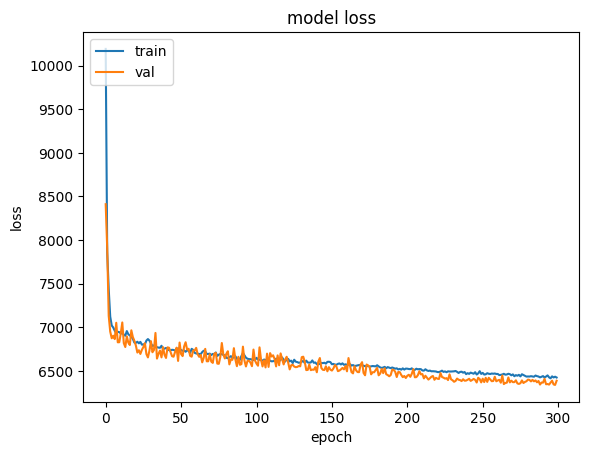

In [28]:
plt.plot(cvae_hist.history['loss'])
plt.plot(cvae_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

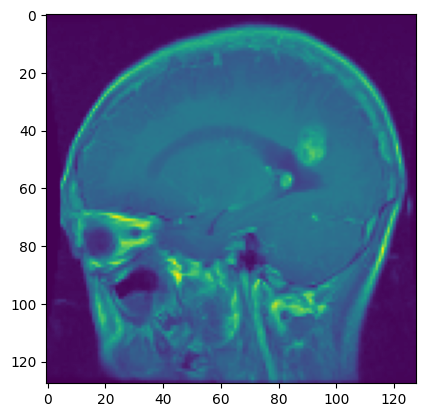

In [29]:
plt.imshow(imgs_train[0])

## Prediccion

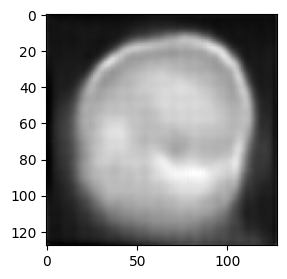

In [53]:
z = np.zeros(shape=(1, latent_dim))  # latent vector
z = np.random.normal(size=(1, latent_dim))
label = np.array([[0, 1, 0, 0]])  # label in one hot encoding
plt.figure(figsize=(3, 3))
plt.imshow(decoder.predict([z, label]).reshape(128, 128), cmap=plt.cm.gray)
plt.show()